In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.argv=['']
del sys
os.chdir("../")

In [2]:
import matplotlib.pyplot as plt
import os
import json
import math
import torch
import logging
import numpy as np
import pandas as pd

from IPython import embed
from common import data_preprocess 
from common.utils import print_to_json
from common.dataloader import load_SMAP_MSL_dataset, load_CSV_dataset, load_SMD_dataset
from common.sliding import BatchSlidingWindow, WindowIterator
from common.config import parse_arguments, set_logger, initialize_config
from networks.mlstm_token_clf import MultiLSTMEncoder
from torch import nn
# from pyts.approximation import SymbolicAggregateApproximation
# from saxpy.znorm import znorm
# from saxpy.paa import paa
# from saxpy.sax import ts_to_string
from gensim.models import Word2Vec

%matplotlib inline

In [3]:
# train
args = parse_arguments()

# load config
config_dir = "./hypers/" if not args["load"] else args["load"]
params = initialize_config(config_dir, args)
params["clear"] = 1
params["nrows"] = None
params["window_size"] = 128

In [6]:
# data_dict = load_SMD_dataset("./datasets/anomaly/SMD/processed", "machine-1-1", params.get("use_dim", "all"))
data_dict = load_SMAP_MSL_dataset("./datasets/anomaly/SMAP-MSL/", "SMAP", params.get("use_dim", "all"))
pp = data_preprocess.preprocessor()
pp.save(params["save_path"])
# data_dict = pp.normalize(data_dict,method="standard")
# data_dict = pp.discretize(data_dict,n_bins=params.get("n_bins", 100))
# vocab_size = pp.build_vocab(data_dict)
# vocab_size

2021-02-02 19:53:59,696 P27982 INFO Saving preprocessor into ./checkpoints/20210202-195348/preprocessor.pkl


In [54]:
sentences = [list(item) for item in data_dict["train"].T.astype(str)]
model = Word2Vec(sentences=sentences, size=10, window=5, min_count=1, workers=4)
pretrain_mat = torch.FloatTensor(np.array([model.wv[str(i)] for i in range(vocab_size)]))
pretrain_mat.shape
# model.save("word2vec.model")

2021-02-02 14:10:00,206 P20790 WARNING consider setting layer size to a multiple of 4 for greater performance
2021-02-02 14:10:00,208 P20790 INFO collecting all words and their counts
2021-02-02 14:10:00,209 P20790 INFO PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-02-02 14:10:00,353 P20790 INFO collected 100 word types from a corpus of 1082202 raw words and 38 sentences
2021-02-02 14:10:00,354 P20790 INFO Loading a fresh vocabulary
2021-02-02 14:10:00,355 P20790 INFO effective_min_count=1 retains 100 unique words (100% of original 100, drops 0)
2021-02-02 14:10:00,356 P20790 INFO effective_min_count=1 leaves 1082202 word corpus (100% of original 1082202, drops 0)
2021-02-02 14:10:00,358 P20790 INFO deleting the raw counts dictionary of 100 items
2021-02-02 14:10:00,358 P20790 INFO sample=0.001 downsamples 50 most-common words
2021-02-02 14:10:00,359 P20790 INFO downsampling leaves estimated 325042 word corpus (30.0% of prior 1082202)
2021-02-02 14:10:00,360 P2

torch.Size([100, 10])

In [7]:
window_dict = data_preprocess.generate_windows(data_dict, data_hdf5_path=params["path"], **params)

2021-02-02 19:54:35,559 P27982 INFO Generating sliding windows (size 128).
2021-02-02 19:54:40,543 P27982 INFO Train windows #: (27011, 128, 25)
2021-02-02 19:54:40,545 P27982 INFO Test windows #: (427489, 128, 25)


In [43]:
window_dict["train_windows"][6]

array([[ 8.,  6.,  9., ...,  7.,  0.,  0.],
       [ 6.,  3.,  8., ...,  7.,  0.,  0.],
       [ 8.,  3.,  7., ...,  7.,  0.,  0.],
       ...,
       [ 6.,  8., 11., ...,  6.,  0.,  0.],
       [ 6., 26., 17., ...,  7.,  0.,  0.],
       [ 4., 11., 14., ...,  5.,  0.,  0.]], dtype=float32)

In [56]:
train_iterator = WindowIterator(window_dict["train_windows"], batch_size=params["batch_size"], shuffle=True)
test_iterator = WindowIterator(window_dict["test_windows"], batch_size=params["batch_size"], shuffle=False)
params['in_channels'] = data_dict["dim"]
params["embedding_dim"] = 32
params["lr"] = 1.0e-3

In [57]:
encoder = MultiLSTMEncoder(vocab_size=vocab_size, pretrain_mat=None, **params)

2021-02-02 14:10:04,147 P20790 INFO Compiling finished.


In [60]:
# training
encoder.fit(
            train_iterator,
            test_iterator=test_iterator.loader,
            test_labels=None,
            **params
        )
encoder.save_encoder()

2021-02-02 14:14:25,609 P20790 INFO Start training for 89 batches.
2021-02-02 14:15:43,569 P20790 INFO Epoch: 1, loss: 2.01830
Traceback (most recent call last):
  File "/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/liujinyang/anaconda3/envs/python36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [ ]:
# test_labels = window_dict["test_labels"][:, -1]
score_dict = encoder.score(test_iterator.loader, window_dict["test_labels"],)

In [ ]:
plt.plot(score_dict["score"])

In [ ]:
# def reconstruction_loader(loader, encoder):
train_iterator_non_shuffle = WindowIterator(window_dict["train_windows"],
                                            batch_size=params["batch_size"], shuffle=False)
loader = train_iterator_non_shuffle.loader

# loader = test_iterator.loader


encoder = encoder.eval()
with torch.no_grad():
    recst_list = []
    real_list = []
    loss = 0
    for batch in loader:
        batch = batch.to(encoder.device)
        return_dict = encoder(batch)
        # diff = return_dict["diff"].max(dim=-1)[0] # chose the most anomaous ts
        recst = return_dict["recst"]  # chose the most anomaous ts
        recst_list.append(recst)
        real_list.append(return_dict["y"])
        loss += return_dict["loss"].item()
print(loss / len(loader))
recst_list = torch.cat(recst_list).cpu().numpy()
real_list = torch.cat(real_list).cpu().numpy()
diff_list = recst_list-real_list

In [48]:
return_dict["recst"].shape

torch.Size([58, 38])

In [49]:
print(recst_list.shape)
print(real_list.shape)
print(diff_list.shape)

(5690, 38)
(5690, 38)
(5690, 38)


In [50]:
real_list[0, 0:10], recst_list[0, 0:10]

(array([ 6.,  3.,  8.,  7.,  0., 91., 96.,  0., 12.,  0.], dtype=float32),
 array([ 6,  3,  8,  7,  0, 91, 96,  0, 10,  0]))

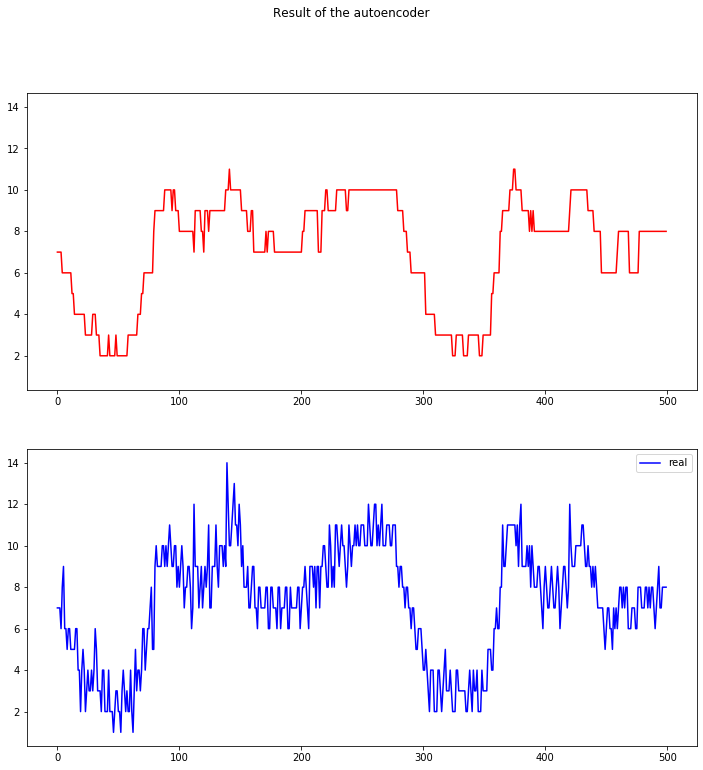

In [51]:
dims = [0,1]
fig, ax = plt.subplots(nrows=len(dims), sharey=True, figsize=(12,12))
i=20
# for i in range(len(dims)):
# ax[0].plot(recst, 'r', label='reconstruction')
# ax[0].legend(loc='best')
ax[0].plot(recst_list[0:500,i].reshape(-1), 'r', label='recst')
ax[1].plot(real_list[0:500,i].reshape(-1), 'b', label='real')
# ax[1].plot(diff_list[15000:-1].reshape(-1), 'b', label='real')
# ax[1].plot(window_dict["test_labels"][15000:, -1].reshape(-1)+0.3, 'r', label='real')
# ax[0].legend(loc='best')
# ax[1].legend(loc='best')

# ax[2].plot(recst, 'r', label='reconstruction')
# ax[2].plot(real, 'b', label='real')
# ax[2].legend(loc='best')

# ax[3].plot(diff, 'g', label='ecart')
# ax[3].legend(loc='best')

plt.legend()
plt.suptitle("Result of the autoencoder")
plt.show()

In [23]:
torch.randint(1,3, (3,))

tensor([2, 1, 1])